In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
image_size = 28
num_classes = 10
num_epochs = 20
batch_size = 64 # 一个批次64张图片

In [4]:
train_dateset = datasets.MNIST(root='./data/hanwritten_digit/', train=True, transform=transforms.ToTensor(), download=True)
test_dateset = datasets.MNIST(root='./data/hanwritten_digit/', train=False, transform=transforms.ToTensor(), download=True)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dateset, batch_size=batch_size, shuffle=True)

indices = range(len(test_dateset))
indices_val = indices[:5000]
indices_test = indices[5000:]

sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

validation_loader = torch.utils.data.DataLoader(dataset=test_dateset, batch_size=batch_size, shuffle=False, sampler=sampler_val)
test_loader = torch.utils.data.DataLoader(dataset=test_dateset, batch_size=batch_size, shuffle=False, sampler=sampler_test)


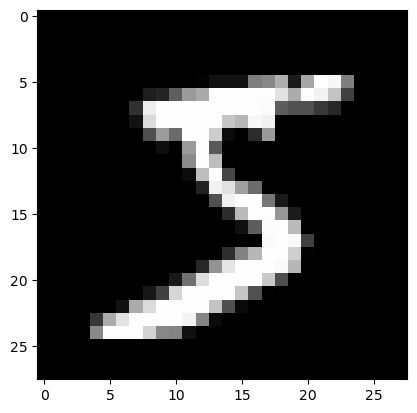

lable:  5


In [6]:
idx = 0

muteimg = train_dateset[idx][0].numpy()

plt.imshow(muteimg[0], cmap='gray')
plt.show()
print("lable: ", train_dateset[idx][1])

In [21]:
depth = [4, 8] # 两个卷积层的厚度
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5, padding=2) # 输入通道1，输出通道4，卷积核5*5，padding=2
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding=2)
        
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1], 512)
        
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x) # x的形状 [batch_size, 1, 28, 28]
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)  # x的形状 [batch_size, depth[1], 14, 14]
        x = self.pool(x) # x的形状 [batch_size, depth[1], 7, 7]
        
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1]) # x的形状 [batch_size, 7*7*depth[1]]
        
        x = F.relu(self.fc1(x))
        
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        x = F.log_softmax(x, dim=1)
        
        return x
        
    def retrieve_features(self, x):
        feature_map1 = F.relu(self.conv1(x))
        
        x = self.pool(feature_map1)
        
        feature_map2 = F.relu(self.conv2(x))
        
        return (feature_map1, feature_map2)

In [23]:
net = ConvNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
def rightness(y_pred, y_true):
    pred = torch.max(y_pred.data, 1)[1]
    rights = pred.eq(y_true.data.view_as(pred)).sum()
    return rights, len(y_true)

In [24]:
record = []
weigths = []

for epoch in range(num_epochs):

    train_rights = []

    for i, (images, labels) in enumerate(train_loader):
        data, target = images.data.clone().requires_grad_(True), labels.clone().detach()

        net.train()

        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        right = rightness(output, target)
        train_rights.append(right)

        if i % 100 == 0:
            net.eval()

            val_rights = []

            for (data, target) in validation_loader:
                data, target = data.clone().requires_grad_(True), target.clone().detach()
                output = net(data)
                right = rightness(output, target)
                val_rights.append(right)
            
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))

            print(f"Epoch {epoch+1}, Batch {i+1}, Train Acc: {train_r[0]/train_r[1]*100:.2f}%, Val Acc: {val_r[0]/val_r[1]*100:.2f}%, Loss: {loss.data:.4f}")

            record.append((100 - 100. * val_r[0] / val_r[1], 100 - 100. * train_r[0] / train_r[1]))

            weigths.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(), net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])
            



Epoch 1, Batch 1, Train Acc: 14.06%, Val Acc: 15.04%, Loss: 2.3061
Epoch 1, Batch 101, Train Acc: 14.96%, Val Acc: 28.96%, Loss: 2.2656
Epoch 1, Batch 201, Train Acc: 19.82%, Val Acc: 40.96%, Loss: 2.1860
Epoch 1, Batch 301, Train Acc: 27.87%, Val Acc: 62.70%, Loss: 1.7123
Epoch 1, Batch 401, Train Acc: 36.78%, Val Acc: 75.68%, Loss: 1.2674
Epoch 1, Batch 501, Train Acc: 44.75%, Val Acc: 82.12%, Loss: 0.5844
Epoch 1, Batch 601, Train Acc: 50.96%, Val Acc: 85.16%, Loss: 0.5772
Epoch 1, Batch 701, Train Acc: 55.80%, Val Acc: 86.32%, Loss: 0.3151
Epoch 1, Batch 801, Train Acc: 59.59%, Val Acc: 87.08%, Loss: 0.4515
Epoch 1, Batch 901, Train Acc: 62.65%, Val Acc: 88.32%, Loss: 0.4150
Epoch 2, Batch 1, Train Acc: 82.81%, Val Acc: 88.58%, Loss: 0.4575
Epoch 2, Batch 101, Train Acc: 88.21%, Val Acc: 88.80%, Loss: 0.4748
Epoch 2, Batch 201, Train Acc: 88.67%, Val Acc: 89.86%, Loss: 0.2642
Epoch 2, Batch 301, Train Acc: 89.17%, Val Acc: 90.36%, Loss: 0.4900
Epoch 2, Batch 401, Train Acc: 89.44%,

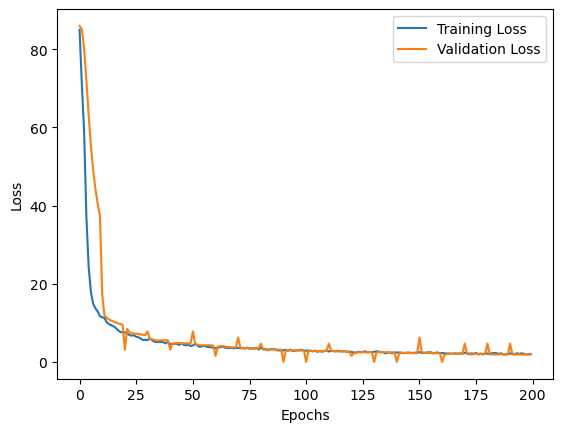

In [26]:
plt.plot(record)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [25]:
net.eval()  # set the model to evaluation mode

vals = []

for data, target in test_loader:
    data, target = data.clone().detach().requires_grad_(True), target.clone().detach()
    output = net(data)
    val = rightness(output, target)

    vals.append(val)

rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
rights_rate = 1.0 * rights[0] / rights[1]
print("Test accuracy: {:.2f}%".format(100.0 * rights_rate))

Test accuracy: 99.10%


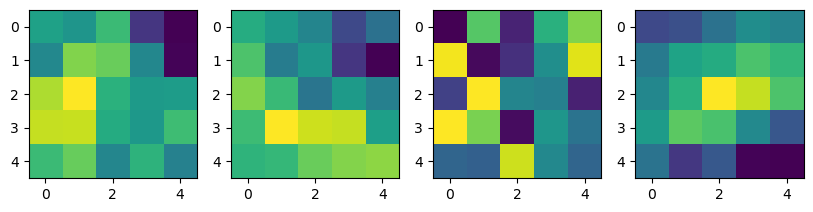

In [27]:
plt.figure(figsize=(10, 7))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(net.conv1.weight.data.numpy()[i,0,...])
plt.show()

In [28]:
input_x = test_dateset[0][0].unsqueeze(0)
input_x.shape

torch.Size([1, 1, 28, 28])

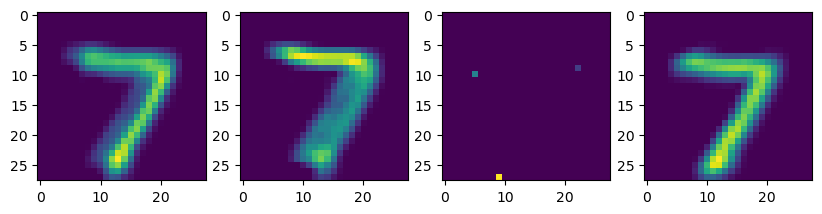

In [30]:
feature_map = net.retrieve_features(input_x)

plt.figure(figsize=(10, 7))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(feature_map[0][0, i, ...].data.numpy())
plt.show()

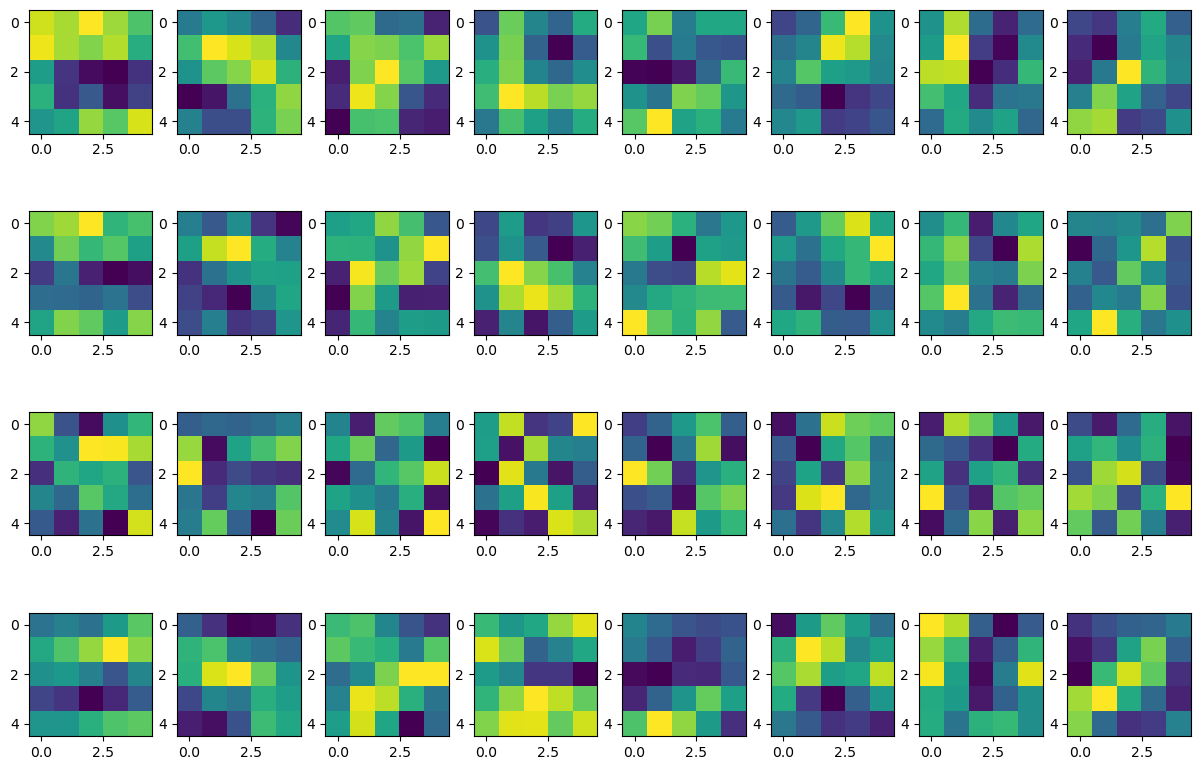

In [32]:
plt.figure(figsize=(15, 10))
for i in range(4):
    for j in range(8):
        plt.subplot(4, 8, i * 8 + j + 1)
        plt.imshow(net.conv2.weight.data.numpy()[j, i, ...])
plt.show()

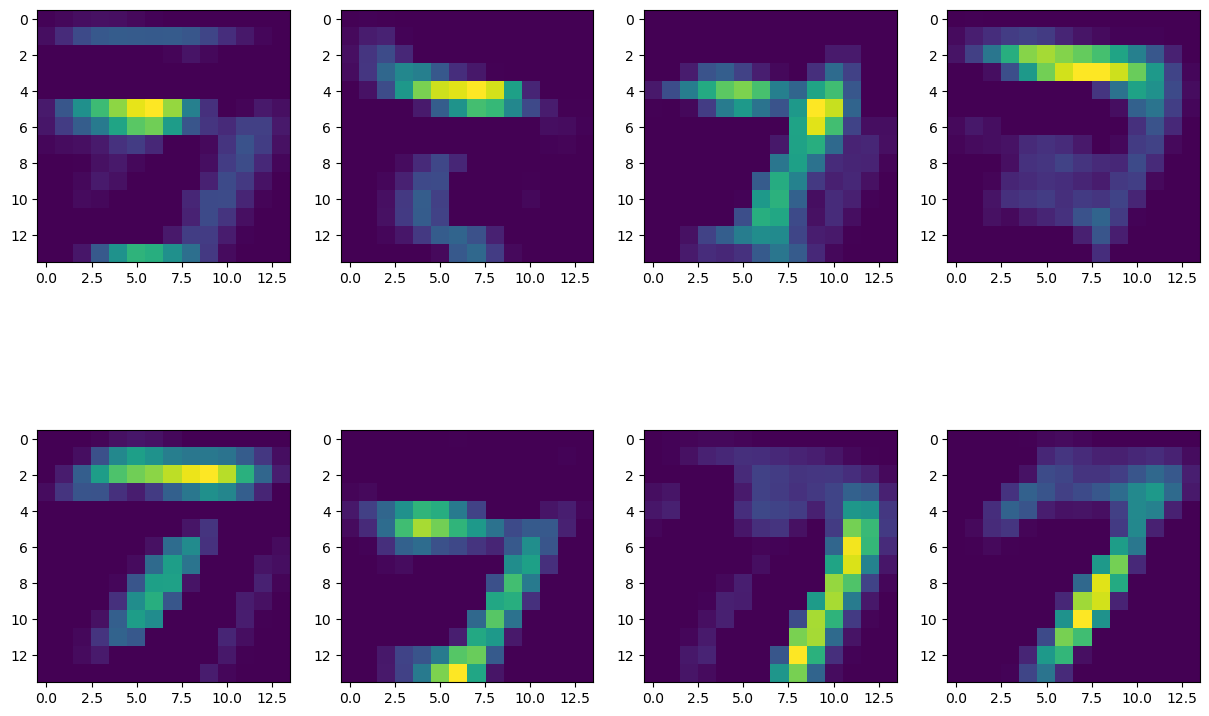

In [35]:
plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(feature_map[1][0, i,...].data.numpy())
plt.show()
        

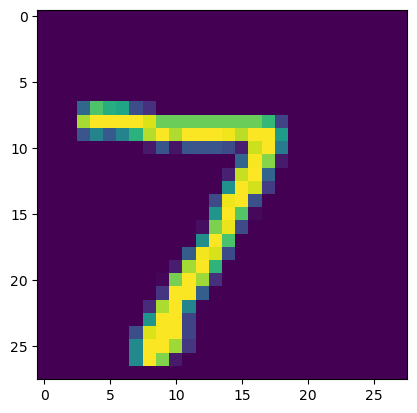

In [39]:
test_a = test_dateset[0][0][0]

move_a = torch.zeros(test_a.size())

move = 3

for i in range(test_a.size()[0]):
    for j in range(0, test_a.size()[1] - move):
        move_a[i, j] = test_a[i, j + move]

img = move_a.numpy()
plt.imshow(img)
plt.show()

In [43]:
prediction = net(move_a.unsqueeze(0).unsqueeze(0))
print(prediction)
la = torch.max(prediction.data, 1)[1]
la

tensor([[-2.0578e+01, -1.1932e+01, -9.8673e+00, -8.2745e+00, -2.0822e+01,
         -2.0810e+01, -3.1163e+01, -3.1633e-04, -1.3008e+01, -1.4146e+01]],
       grad_fn=<LogSoftmaxBackward0>)


tensor([7])